In [1]:


import numpy as np 
import pandas as pd 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
!pip install gdown


In [3]:
# Downloading the data from the gdrive folder
import gdown

file_id = "1KKPx9hp9wBTpjal0Ejg0s0L3Ysslym6Q"
output_file = "clean_data_file.zip"

gdown.download(f"https://drive.google.com/uc?id={file_id}", output_file)

# unzip the data file
!unzip clean_data_file.zip

Downloading...
From (original): https://drive.google.com/uc?id=1KKPx9hp9wBTpjal0Ejg0s0L3Ysslym6Q
From (redirected): https://drive.google.com/uc?id=1KKPx9hp9wBTpjal0Ejg0s0L3Ysslym6Q&confirm=t&uuid=86e465bf-05ff-4651-83b6-1162d109c53f
To: /kaggle/working/clean_data_file.zip
100%|██████████| 236M/236M [00:06<00:00, 36.6MB/s]


Archive:  clean_data_file.zip
  inflating: 100k_pos_tr_spec_R100.csv  


In [4]:
!ls

100k_pos_tr_spec_R100.csv  __notebook__.ipynb  clean_data_file.zip


In [5]:
# Reading the Data from the csv file containing the spectra and the parameters
file_path = '100k_pos_tr_spec_R100.csv'
data = np.genfromtxt(file_path, delimiter=',',skip_header=1)

In [6]:
data.shape

(98664, 280)

In [7]:
train_data = data
new_spec = np.zeros_like(train_data[:,:269])
for i in range(len(train_data)):
    mean_sp = np.mean(train_data[i,:269])
    std_sp = np.std(train_data[i,:269])
    new_spec[i,:269] = (train_data[i,:269] - mean_sp) / std_sp

In [8]:
X = new_spec
Y = data[:,274:]
X.shape, Y.shape

((98664, 269), (98664, 6))

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.20, random_state = 42)

In [10]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((78931, 269), (78931, 6), (19733, 269), (19733, 6))

In [11]:

import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
import pandas as pd
import tensorflow as tf

2024-07-18 09:35:02.883891: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-18 09:35:02.883990: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-18 09:35:03.013822: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [12]:
#Convert features into timesteps
sample_size = X_train.shape[0]
time_steps = X_train.shape[1]
input_dimension = 1

X_reTrain = X_train.reshape(sample_size, time_steps, input_dimension)
X_reTest = X_test.reshape(X_test.shape[0], X_test.shape[1], input_dimension)

print(X_reTrain.shape)
print(X_reTrain[0].shape)
print(X_reTest.shape)

(78931, 269, 1)
(269, 1)
(19733, 269, 1)


## LSTM

In [14]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [15]:
n_timesteps = X_reTrain.shape[1]
n_features = X_reTrain.shape[2]

model = Sequential()

model.add(LSTM(units=128,input_shape=(n_timesteps, n_features),return_sequences=True))
model.add(LSTM(units=64, return_sequences=True))
model.add(LSTM(units=64, return_sequences=True))
model.add(LSTM(units=32))
model.add(Dense(6, activation='linear'))
    
opt = tf.keras.optimizers.Adam(1.1e-3)
    
model.compile(loss='mse', optimizer=opt, metrics=['mae','r2_score'])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [16]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 269, 128)       │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 269, 64)        │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 269, 64)        │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 161,606 (631.27 KB)

 Trainable params: 161,606 (631.27 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
lstm_model=model.fit(X_train, y_train, epochs=100,batch_size=32,
                    validation_split=0.2,shuffle=True)

Epoch 1/100
1974/1974 ━━━━━━━━━━━━━━━━━━━━ 120s 58ms/step - loss: 5.0172 - mae: 1.8432 - r2_score: -0.3260 - val_loss: 3.7626 - val_mae: 1.6677 - val_r2_score: -0.0014
Epoch 2/100
1974/1974 ━━━━━━━━━━━━━━━━━━━━ 139s 58ms/step - loss: 3.7568 - mae: 1.6679 - r2_score: -0.0016 - val_loss: 3.7675 - val_mae: 1.6682 - val_r2_score: -0.0025
Epoch 3/100
1974/1974 ━━━━━━━━━━━━━━━━━━━━ 114s 58ms/step - loss: 3.7648 - mae: 1.6691 - r2_score: -0.0018 - val_loss: 3.7613 - val_mae: 1.6679 - val_r2_score: -9.4247e-04
Epoch 4/100
1974/1974 ━━━━━━━━━━━━━━━━━━━━ 115s 58ms/step - loss: 3.7575 - mae: 1.6679 - r2_score: -0.0018 - val_loss: 3.7641 - val_mae: 1.6680 - val_r2_score: -0.0016
Epoch 5/100
1974/1974 ━━━━━━━━━━━━━━━━━━━━ 116s 59ms/step - loss: 3.7442 - mae: 1.6628 - r2_score: 9.0023e-04 - val_loss: 3.0286 - val_mae: 1.4647 - val_r2_score: 0.1882
Epoch 6/100
1974/1974 ━━━━━━━━━━━━━━━━━━━━ 116s 59ms/step - loss: 2.5647 - mae: 1.3191 - r2_score: 0.3102 - val_loss: 1.8666 - val_mae: 1.0902 - val_r2_sc

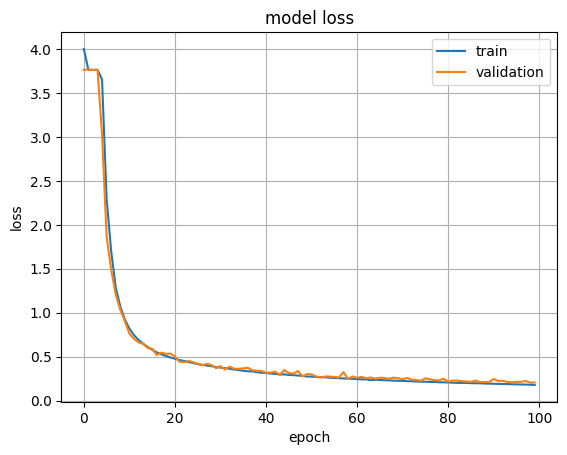

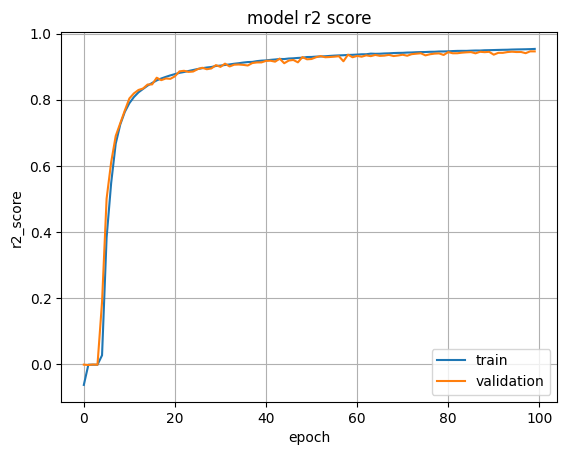

In [18]:
plt.plot(lstm_model.history['loss'])
plt.plot(lstm_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.grid(True)
plt.show()

plt.plot(lstm_model.history['r2_score'])
plt.plot(lstm_model.history['val_r2_score'])
plt.title('model r2 score')
plt.ylabel('r2_score')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.grid(True)
plt.show()

In [19]:
test_loss,test_mae,test_r2_score = model.evaluate(X_test,y_test)

617/617 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - loss: 0.2065 - mae: 0.2805 - r2_score: 0.9457


In [20]:
predictions = model.predict(X_test)
predictions.shape

617/617 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step


(19733, 6)

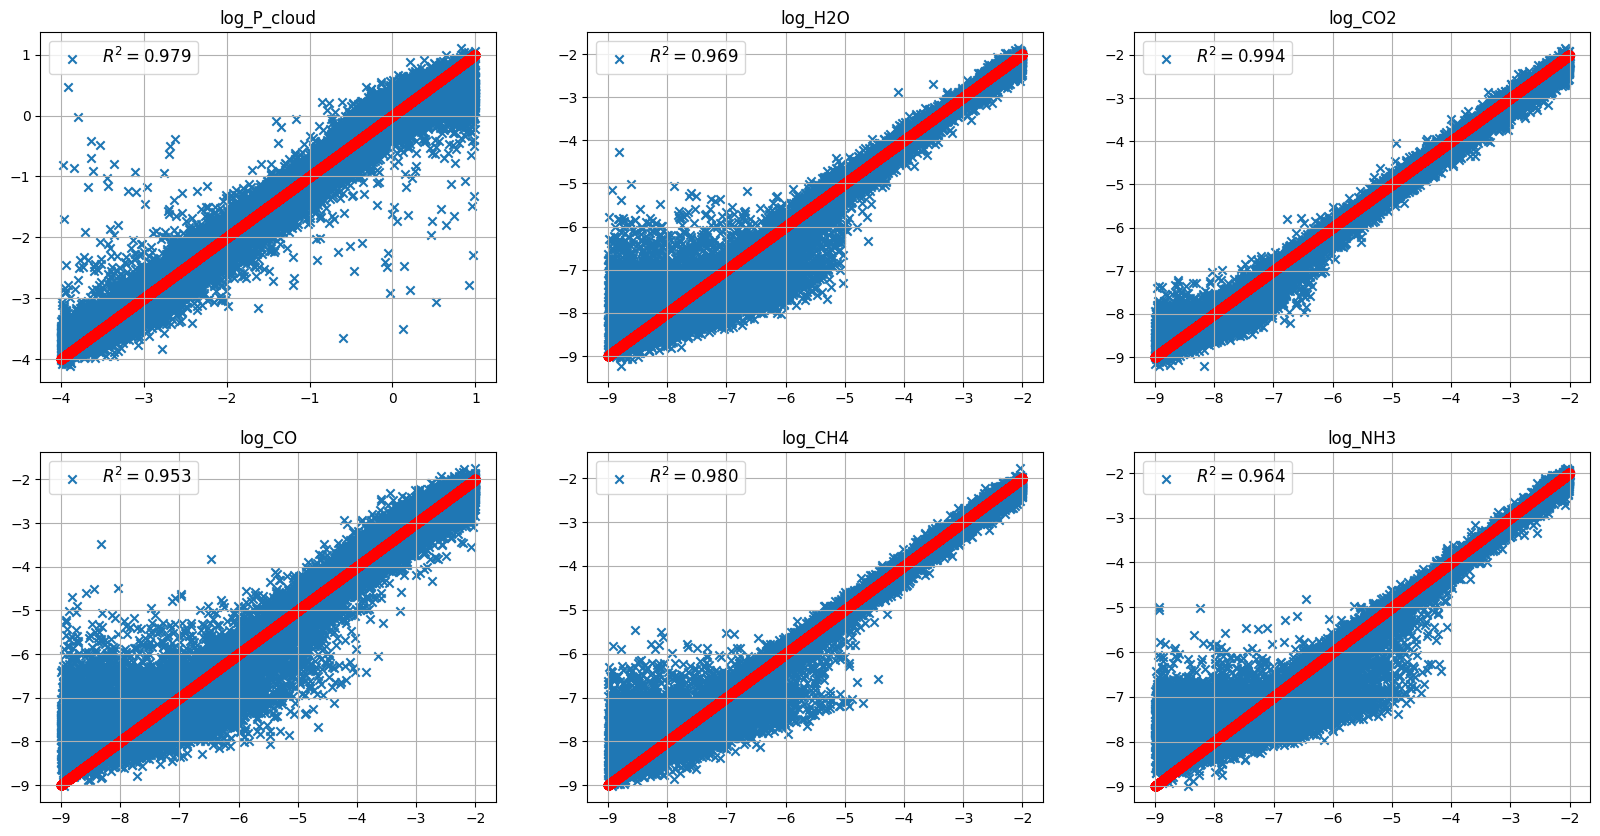

In [21]:
from scipy.stats import pearsonr

keys = ['log_P_cloud', 'log_H2O', 'log_CO2', 'log_CO', 'log_CH4', 'log_NH3']
fig, axs = plt.subplots(2, 3, figsize=(20,10))

for i in range(6):
    if i < 3:
        corr, _ = pearsonr(predictions[:,i], y_test[:,i])
        axs[0,i].scatter(y_test[:,i],predictions[:,i], marker='x', label=f'$R^{2} = ${corr:.3f}')
        axs[0,i].scatter(y_test[:,i],y_test[:,i], color='red')
        axs[0,i].set_title(keys[i])
        axs[0,i].legend(loc='upper left',fontsize=12)
        axs[0,i].grid()
    else:
        corr, _ = pearsonr(predictions[:,i], y_test[:,i])
        axs[1,i-3].scatter(y_test[:,i],predictions[:,i], marker='x',label=f'$R^{2} = ${corr:.3f}')
        axs[1,i-3].scatter(y_test[:,i],y_test[:,i], color='red')
        axs[1,i-3].set_title(keys[i])
        axs[1,i-3].legend(loc= 'upper left',fontsize=12)
        axs[1,i-3].grid()